# Experiment 2

### Description of the experiment...

Talk about trading bot using DQN and how we just take Microsoft stocks...

Explanations...
- How works the actios... 
- How wroks the reward...

NN Architect:

- Input: 12 Nodes (Features)
- Hidden Layer 1: 128 Nodes (ReLU)
- Hidden Layer 2: 64 Nodes (ReLU)
- Output: 7 Nodes (Actions)

Input:
- **close_price:** Most recent closing price of Microsoft stock.
- **sma_5:** Average of last 5 closing prices, shows very short-term trend.
- **sma_20:** Average of last 20 closes, shows short to mid-term trend.
- **sma_50:** Average of last 50 closes, shows longer-term market trend.
- **rsi_14:** Relative Strength Index, detects overbought (>70) or oversold (<30) conditions.
- **macd:** Measures momentum by subtracting 26-EMA from 12-EMA.
- **macd_signal:** 9-day EMA of MACD, used to signal buy/sell crossovers.
- **bollinger_b:** Price's position relative to Bollinger Bands; near 1 means close to upper band.
- **atr_14:** Average True Range; shows volatility based on recent high-low price ranges.
- **momentum_10:** Difference between current price and price 10 days ago.
- **cash:** Current uninvested capital available to buy shares.
- **shares_held:** Number of MSFT shares currently owned by the agent.

Output:
- **Hold:** Do nothing, maintain current position.
- **Buy small:** Buy a small number of shares using a small % of available cash.
- **Buy medium:** Buy more shares using a moderate % of cash.
- **Buy large:** Buy many shares using a large % of available cash.
- **Sell small:** Sell a small number of shares.
- **Sell medium:** Sell a moderate number of shares.
- **Sell all:** Sell all currently held shares.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Get Microsoft Stocks Data

In [2]:
#Read DataFrame
SPY_stocks = pd.read_csv("../data/Preprocessed/SPY_Data.csv")
SPY_stocks.head()

,Unnamed: 0,Date,High,Low,Close
0,32670,1999-07-26,85.789774,84.844432,84.923210
1,32671,1999-07-27,86.469216,85.317081,85.632195
2,32672,1999-07-28,86.538133,85.454929,85.907906
3,32673,1999-07-29,85.238351,84.017284,84.706596
4,32674,1999-07-30,85.297373,83.544552,83.662720


In [3]:
SPY_stocks = SPY_stocks.drop(['Unnamed: 0'], axis=1)
SPY_stocks.head()

,Date,High,Low,Close
0,1999-07-26,85.789774,84.844432,84.923210
1,1999-07-27,86.469216,85.317081,85.632195
2,1999-07-28,86.538133,85.454929,85.907906
3,1999-07-29,85.238351,84.017284,84.706596
4,1999-07-30,85.297373,83.544552,83.662720


### Generate Input Parameters of NN

In [4]:
inputs_SPY = SPY_stocks.copy()

# --- Simple Moving Averages ---
inputs_SPY['SMA_5'] = inputs_SPY['Close'].rolling(window=5).mean()
inputs_SPY['SMA_20'] = inputs_SPY['Close'].rolling(window=20).mean()
inputs_SPY['SMA_50'] = inputs_SPY['Close'].rolling(window=50).mean()

# --- RSI (14) ---
delta = inputs_SPY['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / (avg_loss + 1e-10)
inputs_SPY['RSI_14'] = 100 - (100 / (1 + rs))

# --- MACD and Signal ---
ema_12 = inputs_SPY['Close'].ewm(span=12, adjust=False).mean()
ema_26 = inputs_SPY['Close'].ewm(span=26, adjust=False).mean()
inputs_SPY['MACD'] = ema_12 - ema_26
inputs_SPY['MACD_Signal'] = inputs_SPY['MACD'].ewm(span=9, adjust=False).mean()

# --- Bollinger Bands (%B) ---
sma_20 = inputs_SPY['Close'].rolling(window=20).mean()
std_20 = inputs_SPY['Close'].rolling(window=20).std()
upper_band = sma_20 + 2 * std_20
lower_band = sma_20 - 2 * std_20
inputs_SPY['Bollinger_b'] = (inputs_SPY['Close'] - lower_band) / (upper_band - lower_band + 1e-10)

# --- ATR (14) ---
high_low = inputs_SPY['High'] - inputs_SPY['Low']
high_close = np.abs(inputs_SPY['High'] - inputs_SPY['Close'].shift())
low_close = np.abs(inputs_SPY['Low'] - inputs_SPY['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
inputs_SPY['ATR_14'] = true_range.rolling(window=14).mean()

# --- Momentum (10) ---
inputs_SPY['Momentum_10'] = inputs_SPY['Close'] - inputs_SPY['Close'].shift(10)

inputs_SPY = inputs_SPY.drop(['Low', 'High'], axis=1)

In [5]:
inputs_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10
0,1999-07-26,84.923210,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,1999-07-27,85.632195,NaN,NaN,NaN,NaN,0.056557,0.011311,NaN,NaN,NaN
2,1999-07-28,85.907906,NaN,NaN,NaN,NaN,0.122218,0.033493,NaN,NaN,NaN
3,1999-07-29,84.706596,NaN,NaN,NaN,NaN,0.076438,0.042082,NaN,NaN,NaN
4,1999-07-30,83.662720,84.966525,NaN,NaN,NaN,-0.043573,0.024951,NaN,NaN,NaN


In [6]:
inputs_SPY = inputs_SPY[inputs_SPY['Date'] >= '2000-01-01']
inputs_SPY = inputs_SPY[inputs_SPY['Date'] <= '2025-01-01']

In [7]:
inputs_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10
112,2000-01-03,92.142548,92.746373,90.878498,88.689529,64.905610,1.209557,1.134688,0.706253,1.204466,1.742256
113,2000-01-04,88.539215,91.930681,90.793552,88.815921,48.025427,0.852350,1.078220,0.150906,1.382858,-1.207680
114,2000-01-05,88.697601,91.067470,90.753062,88.953776,46.416858,0.575409,0.977658,0.190058,1.478556,-2.415451
115,2000-01-06,87.272079,89.940936,90.669935,89.083660,38.638978,0.238158,0.829758,0.025521,1.580544,-4.078476
116,2000-01-07,92.340523,89.798393,90.818503,89.285683,56.171171,0.375536,0.738913,0.711398,1.873088,-0.465248


In [8]:
inputs_SPY.shape

(6289, 11)

In [9]:
print("Oldst Date: ", inputs_SPY['Date'].min())
print("Recent Date: ", inputs_SPY['Date'].max())

Oldst Date:  2000-01-03
Recent Date:  2024-12-31


### Get years 2000-2004 to training and 2005-2018 to Testing

In [10]:
years = ['2000', '2001', '2002', '2003', '2004']
training_SPY = inputs_SPY[inputs_SPY['Date'].str[:4].isin(years)]
training_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10
112,2000-01-03,92.142548,92.746373,90.878498,88.689529,64.905610,1.209557,1.134688,0.706253,1.204466,1.742256
113,2000-01-04,88.539215,91.930681,90.793552,88.815921,48.025427,0.852350,1.078220,0.150906,1.382858,-1.207680
114,2000-01-05,88.697601,91.067470,90.753062,88.953776,46.416858,0.575409,0.977658,0.190058,1.478556,-2.415451
115,2000-01-06,87.272079,89.940936,90.669935,89.083660,38.638978,0.238158,0.829758,0.025521,1.580544,-4.078476
116,2000-01-07,92.340523,89.798393,90.818503,89.285683,56.171171,0.375536,0.738913,0.711398,1.873088,-0.465248


In [11]:
print("Oldst Date: ", training_SPY['Date'].min())
print("Recent Date: ", training_SPY['Date'].max())

Oldst Date:  2000-01-03
Recent Date:  2004-12-31


In [12]:
training_SPY.to_csv('../Data/Train_Test/training_SPY_e2.csv')

In [13]:
training_SPY = training_SPY.drop(['Date'], axis=1)
training_SPY.shape

(1256, 10)

In [14]:
testing_SPY = inputs_SPY.copy()

testing_SPY = testing_SPY[testing_SPY['Date'] >= '2005-01-01']
testing_SPY = testing_SPY[testing_SPY['Date'] <= '2019-01-01']
testing_SPY.head()

,Date,Close,SMA_5,SMA_20,SMA_50,RSI_14,MACD,MACD_Signal,Bollinger_b,ATR_14,Momentum_10
1368,2005-01-03,82.073990,82.529770,81.819365,80.077552,55.102031,0.679712,0.757610,0.586922,0.627123,0.586655
1369,2005-01-04,81.071144,82.209119,81.825521,80.209643,38.224783,0.540785,0.714245,0.239910,0.691627,-0.436623
1370,2005-01-05,80.511719,81.752016,81.841393,80.332306,32.672397,0.381150,0.647626,0.018346,0.713740,-1.623726
1371,2005-01-06,80.921066,81.408170,81.854305,80.440407,38.622213,0.284391,0.574979,0.151279,0.711091,-1.412231
1372,2005-01-07,80.805069,81.076598,81.847157,80.528044,42.354400,0.196088,0.499201,0.116829,0.711969,-1.589622


In [15]:
print("Oldst Date: ", testing_SPY['Date'].min())
print("Recent Date: ", testing_SPY['Date'].max())

Oldst Date:  2005-01-03
Recent Date:  2018-12-31


In [16]:
testing_SPY.shape

(3523, 11)

In [17]:
testing_SPY.to_csv('../Data/Train_Test/testing_SPY_e2.csv')

### Creating the architecture of the Neural Network

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque
import math

In [19]:
class DQN(nn.Module):
    def __init__(self, input_dim=12, output_dim=7):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64) #self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Create Custom Trading Environment

In [20]:
#Custom Trading Environment for a single stock
class TradingEnv:

    """
    Initialize the trading environment.
    """
    def __init__(self, df, initial_cash=10_000):
        # Load and sort data
        self.df = df.reset_index(drop=True).copy()
        self.max_steps = len(self.df) - 2  # total steps (days)

        # Initial portfolio settings
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.shares_held = 0.0
        self.current_step = 0
        self.prev_portfolio_value = initial_cash

        # Track total reward and history
        self.total_reward = 0
        self.history = []

        # Action mapping
        self.action_mapping = {
            0: 'hold',
            1: 0.10,  # buy small
            2: 0.25,  # buy medium
            3: 0.50,  # buy large
            4: 0.10,  # sell small
            5: 0.50,  # sell medium
            6: 1.00   # sell all
        }

        # Define input features
        self.feature_cols = [
            'Close',
            'SMA_5', 'SMA_20', 'SMA_50',
            'RSI_14',
            'MACD', 'MACD_Signal',
            'Bollinger_b',
            'ATR_14',
            'Momentum_10'
        ]

    """
    Reset the environment to the initial state.
    """
    def reset(self):
        self.cash = self.initial_cash          # Reset available capital
        self.shares_held = 0.0                 # No shares at start
        self.current_step = 0                  # Start at the beginning of the dataset
        self.prev_portfolio_value = self.initial_cash  # Track portfolio for reward calc
        self.total_reward = 0.0                # Reset reward tracker
        self.history = []                      # Clear history
    
        return self._get_state()

    """
    Construct the current state vector.
    """
    def _get_state(self):
        row = self.df.loc[self.current_step]
    
        # Extract the market features
        features = []
        for col in self.feature_cols:
            features.append(row[col])
    
        # Append portfolio state
        features.append(self.cash)
        features.append(self.shares_held)
    
        return np.array(features, dtype=np.float32)


    """
    Execute one time step in the environment.
    """
    def step(self, action):
        done = False
        reward = 0.0
        invalid_action_penalty = -.01
    
        current_price = self.df.loc[self.current_step, 'Close']
        action_type = self.action_mapping[action]
    
        # Apply action
        if action == 0:
            pass  # hold
        elif 1 <= action <= 3:  # buy
            percent = self.action_mapping[action]
            if self.cash >= current_price:
                self._buy(percent)
            else:
                reward += invalid_action_penalty  # penalize invalid buy
        elif 4 <= action <= 6:  # sell
            percent = self.action_mapping[action]
            if self.shares_held > 0:
                self._sell(percent)
            else:
                reward += invalid_action_penalty  # penalize invalid sell

        # Advance to next time step
        self.current_step += 1
        done = self.current_step >= self.max_steps - 1
    
        if done:
            final_value = self._get_portfolio_value()

            portfolio_value = self._get_portfolio_value()
            reward += ((portfolio_value - self.prev_portfolio_value) / self.prev_portfolio_value) * 10
            self.prev_portfolio_value = portfolio_value
            self.total_reward += reward
            
            reward += self._calculate_final_reward(self.initial_cash, final_value) * 30
                
            next_state = self._get_state()
            return next_state, reward, done, {}
        
        self.current_price = self.df.loc[self.current_step, 'Close']
        
        # Calculate new portfolio value
        portfolio_value = self._get_portfolio_value()
        reward += ((portfolio_value - self.prev_portfolio_value) / self.prev_portfolio_value) * 10
        self.prev_portfolio_value = portfolio_value
        self.total_reward += reward
    
        # Log history for debugging/analysis
        self.history.append({
            'step': self.current_step,
            'cash': self.cash,
            'shares_held': self.shares_held,
            'portfolio_value': portfolio_value,
            'action': action,
            'reward': reward
        })
    
        # Return next state
        next_state = self._get_state()
        return next_state, reward, done, {}

    """
    Execute a buy order using a percentage of available cash.
    """
    def _buy(self, percent):
        current_price = self.df.loc[self.current_step, 'Close']
        
        # Capital to use for this transaction
        amount_to_spend = self.cash * percent
    
        # Number of whole shares we can buy
        shares_to_buy = int(amount_to_spend // current_price)
    
        if shares_to_buy > 0:
            self.cash -= shares_to_buy * current_price
            self.shares_held += shares_to_buy
    
    """
    Execute a sell order using a percentage of held shares.
    """
    def _sell(self, percent):
        current_price = self.df.loc[self.current_step, 'Close']
    
        # Determine how many shares to sell
        shares_to_sell = int(self.shares_held * percent)
    
        if shares_to_sell > 0:
            self.cash += shares_to_sell * current_price
            self.shares_held -= shares_to_sell

    """
    Calculate the current total portfolio value:
    cash + (shares_held × current market price)
    """
    def _get_portfolio_value(self):
        current_price = self.df.loc[self.current_step, 'Close']
        return self.cash + (self.shares_held * current_price)

    """
    Generate Final Reward
    """
    def _calculate_final_reward(self, initial_value, final_value):
        if initial_value == 0:
            return 0 
        
        change_ratio = (final_value - initial_value) / initial_value
        reward = change_ratio * 10  
        
        return reward
    # def _calculate_final_reward(self, initial_value, final_value):
    #     change_ratio = (final_value - initial_value) / initial_value
        
    #     if change_ratio > 0:
    #         reward = math.floor(change_ratio * 10) + 1  
    #         return max(1, reward) 
    #     elif change_ratio < 0:
    #         reward = math.ceil(abs(change_ratio) * 10) 
    #         return -max(1, reward) 
    #     else:
    #         return 0
    

### Initializing the hyperparameters

In [21]:
# Learning rate for optimizer (controls how fast the model learns)
learning_rate = 5e-4
# Number of experiences used for each learning step
minibatch_size = 100
# Discount factor (γ): how much future rewards are valued vs. immediate rewards
#discount_factor = 0.95
discount_factor = 0.99
# Size of the experience replay buffer
replay_buffer_size = int(1e5)
# Soft update rate (τ): how fast target network updates towards the main network
interpolation_parameter = 1e-3

### Implementing Experience Replay

In [22]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.capacity = capacity
        self.memory = []

    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
    
        states = torch.from_numpy(
            np.vstack([e[0] for e in experiences if e is not None])
        ).float().to(self.device)
    
        actions = torch.from_numpy(
            np.vstack([e[1] for e in experiences if e is not None])
        ).long().to(self.device)
    
        rewards = torch.from_numpy(
            np.vstack([e[2] for e in experiences if e is not None])
        ).float().to(self.device)
    
        next_states = torch.from_numpy(
            np.vstack([e[3] for e in experiences if e is not None])
        ).float().to(self.device)
    
        dones = torch.from_numpy(
            np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)
        ).float().to(self.device)
    
        return states, next_states, actions, rewards, dones

    def __len__(self):
        return len(self.memory)

### Create DQN Agent

In [23]:
class Agent:
    def __init__(self, state_size, action_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = DQN(state_size, action_size).to(self.device)
        self.target_qnetwork = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
        self.memory = ReplayMemory(replay_buffer_size)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
          if len(self.memory.memory) > minibatch_size:
            experiences = self.memory.sample(100)
            self.learn(experiences, discount_factor)

    def act(self, state, epsilon = 0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.local_qnetwork.eval()
        with torch.no_grad():
          action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon:
          return np.argmax(action_values.cpu().data.numpy())
        else:
          return random.choice(np.arange(self.action_size))

    def learn(self, experiences, discount_factor):
        states, next_states, actions, rewards, dones = experiences
        next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
        q_expected = self.local_qnetwork(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

    def soft_update(self, local_model, target_model, interpolation_parameter):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
          target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)
        

### Initializing the DQN agent and Envirionment

In [24]:
agent = Agent(12, 7)
env = TradingEnv(training_SPY)

In [25]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
#epsilon_ending_value  = 0.1 
epsilon_decay_value  = 0.995
#epsilon_decay_value  = 0.95
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)
total_value_on_100_episodes = deque(maxlen = 100)

for episode in range(1, number_episodes + 1):
    state = env.reset()
    score = 0
    #for t in range(maximum_number_timesteps_per_episode):
    for t in range(env.max_steps):
        action = agent.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
          break
    scores_on_100_episodes.append(score)
    total_value_on_100_episodes.append(env.prev_portfolio_value)
    epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
    
    print('\rEpisode {}  Score: {:.2f} Initial Catch: {:.2f}  Total Catch {:.2f}, Total Holds:{}, Price stock: {:.2f}, Total Value: {:.2f}'.format(episode, score, env.initial_cash, env.cash, env.shares_held, env.current_price, env.prev_portfolio_value), end = "")
    
    if episode % 100 == 0:
        print('')
        print('\rEpisode {}  Average Reward: {:.2f} Average Total Value: {:.2f}'.format(episode, np.mean(scores_on_100_episodes), np.mean(total_value_on_100_episodes)))

torch.save(agent.local_qnetwork.state_dict(), 'Models/dqn_trading_Experiment_2.pth')

Episode 100  Score: 51.29 Initial Catch: 10000.00  Total Catch 7949.89, Total Holds:45.0, Price stock: 82.67, Total Value: 11675.778
Episode 100  Average Reward: 9.76 Average Total Value: 10355.98
Episode 200  Score: 10.82 Initial Catch: 10000.00  Total Catch 10391.78, Total Holds:0.0, Price stock: 82.67, Total Value: 10391.7834
Episode 200  Average Reward: 20.65 Average Total Value: 10704.43
Episode 300  Score: 30.57 Initial Catch: 10000.00  Total Catch 570.74, Total Holds:126.0, Price stock: 82.67, Total Value: 11003.1900
Episode 300  Average Reward: 13.34 Average Total Value: 10458.69
Episode 400  Score: 31.70 Initial Catch: 10000.00  Total Catch 11112.89, Total Holds:0.0, Price stock: 82.67, Total Value: 11112.899
Episode 400  Average Reward: 17.18 Average Total Value: 10605.87
Episode 500  Score: 27.05 Initial Catch: 10000.00  Total Catch 10893.71, Total Holds:0.0, Price stock: 82.67, Total Value: 10893.711
Episode 500  Average Reward: 19.15 Average Total Value: 10659.11
Episode 6

# Testing model

In [27]:
test_env = TradingEnv(testing_SPY)

In [28]:
# Recreate the model architecture
trained_model = DQN(input_dim=12, output_dim=7)  # adjust if your input/output sizes changed

# Load the weights
trained_model.load_state_dict(torch.load('Models/dqn_trading_Experiment_2.pth'))
trained_model.eval()  # Set to evaluation mode

DQN(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=7, bias=True)
)

In [29]:
state = test_env.reset()
done = False
total_reward = 0
actions = []
stocks_held = []
actual_cash = []
stock_price = []
portfolio_values = []

while not done:
    
    state_tensor = torch.from_numpy(state).float().unsqueeze(0)
    
    with torch.no_grad():
        action_values = trained_model(state_tensor)

    action = torch.argmax(action_values).item()
    next_state, reward, done, _ = test_env.step(action)

    total_reward += reward


    actions.append(action)
    stocks_held.append(test_env.shares_held)
    actual_cash.append(test_env.cash)
    stock_price.append(test_env.current_price)
    portfolio_values.append(test_env.prev_portfolio_value)
    
    state = next_state

print("Total Reward:", total_reward)
print("Final Portfolio Value:", test_env.prev_portfolio_value)

Total Reward: 212.0270130236998
Final Portfolio Value: 17163.629478454586


### Visualize Result

In [30]:
def group_actions(valor):
    valor = valor.lower()
    if "buy" in valor:
        return "buy"
    elif "sell" in valor:
        return "sell"
    elif "hold" in valor:
        return "hold"

In [31]:
#SPY_stocks = SPY_stocks.drop(['Unnamed: 0'], axis=1)

test_vis_SPY = SPY_stocks[SPY_stocks['Date'] >= '2005-01-01']
test_vis_SPY = test_vis_SPY[test_vis_SPY['Date'] <= '2019-01-01']
test_vis_SPY = test_vis_SPY.drop(test_vis_SPY.index[0])
test_vis_SPY = test_vis_SPY.drop(test_vis_SPY.tail(2).index)
test_vis_SPY = test_vis_SPY.drop(['High', 'Low'], axis=1)
test_vis_SPY['v_Close'] = stock_price
test_vis_SPY['Prev_Action'] = actions
test_vis_SPY['Stocks_Held'] = stocks_held
test_vis_SPY['Actual_Cash'] = actual_cash
test_vis_SPY['Portfolio_Values'] = portfolio_values

test_vis_SPY['Prev_Action'] = test_vis_SPY['Prev_Action'].map({
    0: "hold",
    1: "Buy Small",
    2: "Buy Medium",
    3: "Buy Large",
    4: "Sell Small",
    5: "Sell Medium",
    6: "Sell All"
})

test_vis_SPY['Stocks_Money'] = test_vis_SPY['Close'] * test_vis_SPY['Stocks_Held']
test_vis_SPY['Color_Action'] = test_vis_SPY['Prev_Action'].apply(group_actions)

test_vis_SPY.head(10)

,Date,Close,v_Close,Prev_Action,Stocks_Held,Actual_Cash,Portfolio_Values,Stocks_Money,Color_Action
1369,2005-01-04,81.071144,81.071144,Buy Large,60.0,5075.560608,9939.829254,4864.268646,buy
1370,2005-01-05,80.511719,80.511719,hold,60.0,5075.560608,9906.263733,4830.703125,hold
1371,2005-01-06,80.921066,80.921066,hold,60.0,5075.560608,9930.824585,4855.263977,hold
1372,2005-01-07,80.805069,80.805069,hold,60.0,5075.560608,9923.864746,4848.304138,hold
1373,2005-01-10,81.187134,81.187134,hold,60.0,5075.560608,9946.788635,4871.228027,hold
1374,2005-01-11,80.627693,80.627693,hold,60.0,5075.560608,9913.222198,4837.661591,hold
1375,2005-01-12,80.893738,80.893738,hold,60.0,5075.560608,9929.184875,4853.624268,hold
1376,2005-01-13,80.245613,80.245613,hold,60.0,5075.560608,9890.297394,4814.736786,hold
1377,2005-01-14,80.668640,80.668640,hold,60.0,5075.560608,9915.679016,4840.118408,hold
1378,2005-01-18,81.507767,81.507767,hold,60.0,5075.560608,9966.026611,4890.466003,hold


In [32]:
normal_final_invest = 10000 * (test_vis_SPY['Close'].iloc[-1] / test_vis_SPY['Close'].iloc[0])

print("Stock Prices First Day:", test_vis_SPY['Close'].iloc[0])
print("Stock Prices Last Day:", test_vis_SPY['Close'].iloc[-1])
print("Final Portfolio Value if you will invest $10,000 normal:", normal_final_invest)
print("Final Portfolio Value if invest $10,000 with Trading Bot:", test_env.prev_portfolio_value)

Stock Prices First Day: 81.0711441040039
Stock Prices Last Day: 224.37730407714844
Final Portfolio Value if you will invest $10,000 normal: 27676.592770086118
Final Portfolio Value if invest $10,000 with Trading Bot: 17163.629478454586


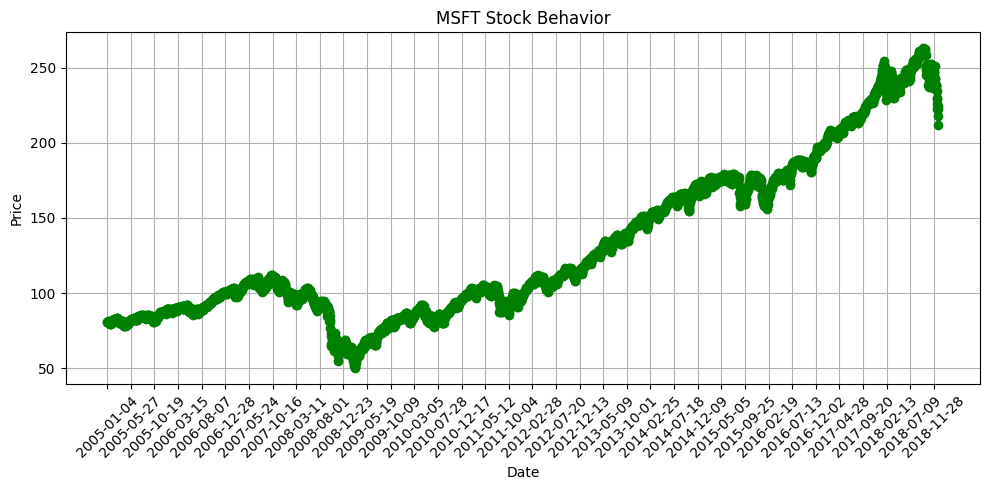

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(test_vis_SPY['Date'], test_vis_SPY['Close'], marker='o', linestyle='-', color='green')
plt.title('MSFT Stock Behavior')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()

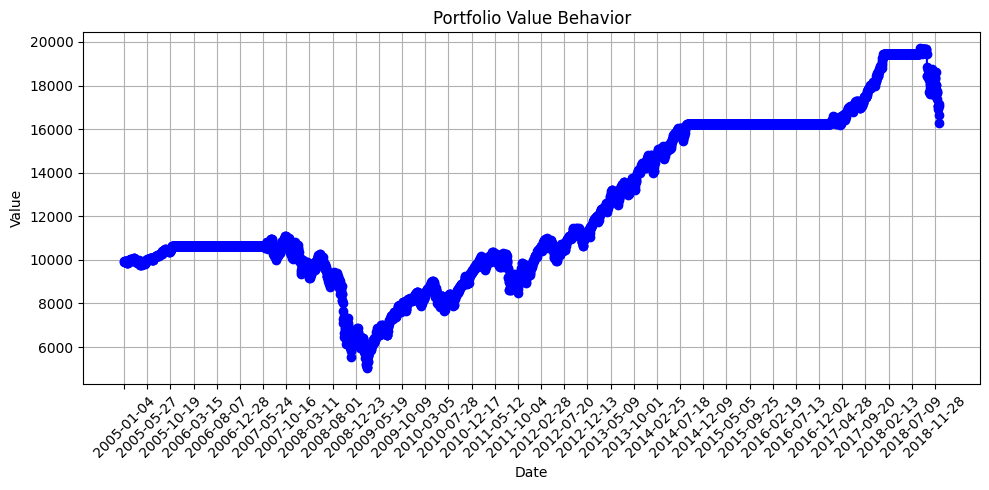

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(test_vis_SPY['Date'], test_vis_SPY['Portfolio_Values'], marker='o', linestyle='-', color='blue')
plt.title('Portfolio Value Behavior')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()

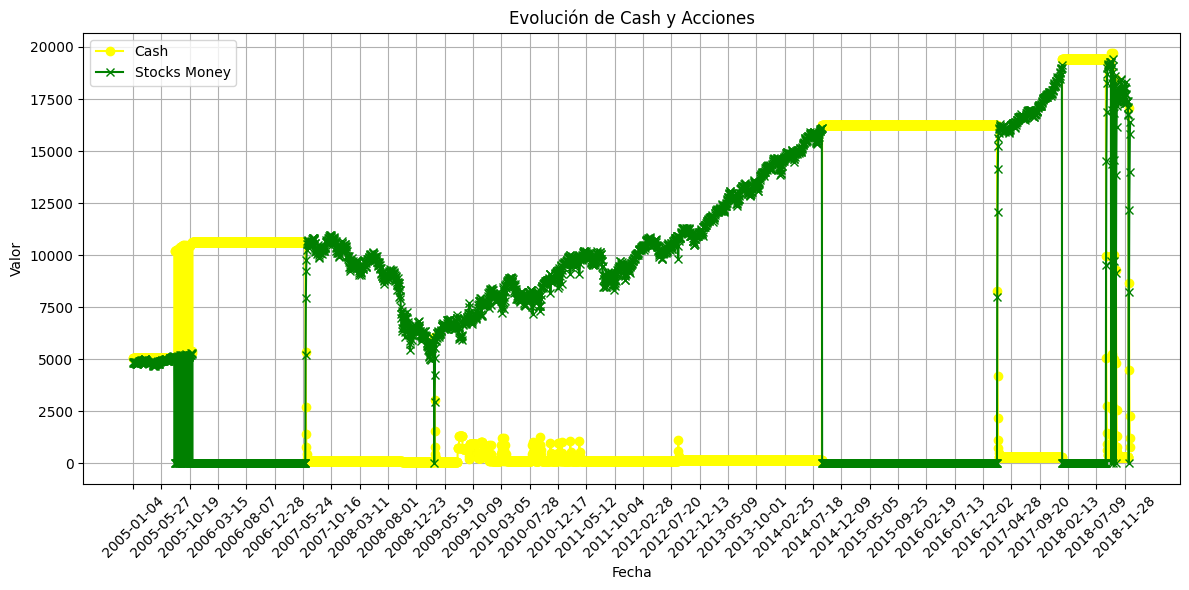

In [35]:
plt.figure(figsize=(12, 6))

plt.plot(test_vis_SPY['Date'], test_vis_SPY['Actual_Cash'], label='Cash', color='Yellow', marker='o')
plt.plot(test_vis_SPY['Date'], test_vis_SPY['Stocks_Money'], label='Stocks Money', color='Green', marker='x')

# Configuración general
plt.title('Evolución de Cash y Acciones')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()

# Mostrar
plt.show()

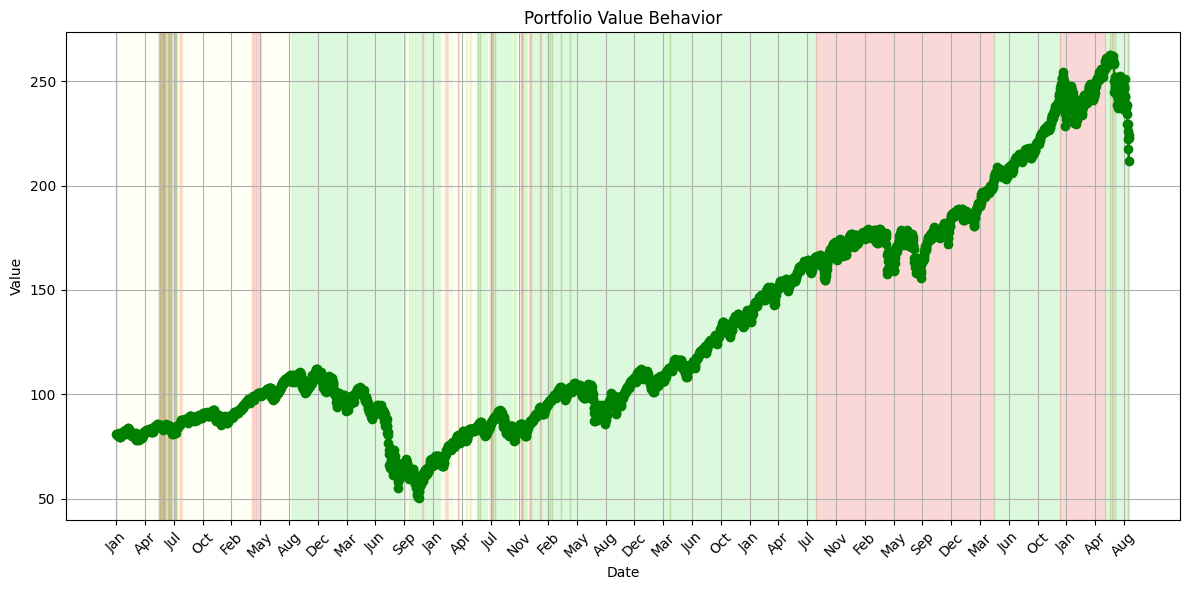

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(test_vis_SPY['Date'], test_vis_SPY['Close'], color='green', marker='o')

state_colors = {
    'buy': 'lightgreen',
    'sell': 'lightcoral',
    'hold': 'lightyellow'
}

prev_state = None
start_date = None

for i, row in test_vis_SPY.iterrows():
    current_state = row['Color_Action']
    current_date = row['Date']

    if current_state != prev_state:
        if prev_state is not None:
            ax.axvspan(start_date, current_date, color=state_colors[prev_state], alpha=0.3)
        start_date = current_date
        prev_state = current_state

ax.axvspan(start_date, test_vis_SPY['Date'].iloc[-1], color=state_colors[prev_state], alpha=0.3)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title("Portfolio Value Behavior")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)

skip = 100
plt.xticks(test_vis_SPY['Date'][::skip], rotation=45)

plt.tight_layout()
plt.show()